### Cab-Driver Agent

In [16]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    
    def build_model(self):
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []
            
            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])
    
    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

### DQN block

In [10]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 15000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

In [11]:
start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state
    initial_state = env.state_init


    total_time = 0  
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipulated time skip
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)

Saving Model 0
episode 9, reward -137.0, memory_length 1400, epsilon 0.9955001547284723 total_time 730.0
episode 19, reward -181.0, memory_length 2000, epsilon 0.9905350769930761 total_time 724.0
episode 29, reward -172.0, memory_length 2000, epsilon 0.9855947626861951 total_time 721.0
episode 39, reward 68.0, memory_length 2000, epsilon 0.9806790882997144 total_time 722.0
episode 49, reward -245.0, memory_length 2000, epsilon 0.9757879309415182 total_time 725.0
episode 59, reward -110.0, memory_length 2000, epsilon 0.9709211683324178 total_time 725.0
episode 69, reward 159.0, memory_length 2000, epsilon 0.9660786788030947 total_time 723.0
episode 79, reward -297.0, memory_length 2000, epsilon 0.9612603412910584 total_time 721.0
episode 89, reward 202.0, memory_length 2000, epsilon 0.9564660353376199 total_time 727.0
episode 99, reward -48.0, memory_length 2000, epsilon 0.9516956410848808 total_time 723.0
episode 109, reward -165.0, memory_length 2000, epsilon 0.9469490392727365 total_

episode 919, reward 579.0, memory_length 2000, epsilon 0.631593050259626 total_time 729.0
episode 929, reward 596.0, memory_length 2000, epsilon 0.6284429667796988 total_time 724.0
episode 939, reward 550.0, memory_length 2000, epsilon 0.6253085944066726 total_time 722.0
episode 949, reward 544.0, memory_length 2000, epsilon 0.6221898547810748 total_time 731.0
episode 959, reward 437.0, memory_length 2000, epsilon 0.6190866699342522 total_time 727.0
episode 969, reward 640.0, memory_length 2000, epsilon 0.6159989622864221 total_time 725.0
episode 979, reward 478.0, memory_length 2000, epsilon 0.6129266546447325 total_time 723.0
episode 989, reward 330.0, memory_length 2000, epsilon 0.6098696702013323 total_time 722.0
episode 999, reward 604.0, memory_length 2000, epsilon 0.6068279325314512 total_time 727.0
Saving Model 1000
episode 1009, reward 627.0, memory_length 2000, epsilon 0.6038013655914889 total_time 724.0
episode 1019, reward 662.0, memory_length 2000, epsilon 0.60078989371711

episode 1809, reward 992.0, memory_length 2000, epsilon 0.40474015917966877 total_time 726.0
episode 1819, reward 924.0, memory_length 2000, epsilon 0.4027215092142031 total_time 729.0
episode 1829, reward 955.0, memory_length 2000, epsilon 0.4007129273074429 total_time 729.0
episode 1839, reward 1132.0, memory_length 2000, epsilon 0.39871436324473586 total_time 722.0
episode 1849, reward 283.0, memory_length 2000, epsilon 0.3967257670618763 total_time 721.0
episode 1859, reward 617.0, memory_length 2000, epsilon 0.3947470890438561 total_time 726.0
episode 1869, reward 736.0, memory_length 2000, epsilon 0.3927782797236218 total_time 723.0
episode 1879, reward 1041.0, memory_length 2000, epsilon 0.3908192898808378 total_time 721.0
episode 1889, reward 932.0, memory_length 2000, epsilon 0.388870070540656 total_time 727.0
episode 1899, reward 668.0, memory_length 2000, epsilon 0.38693057297249134 total_time 727.0
episode 1909, reward 1059.0, memory_length 2000, epsilon 0.3850007486888037 

episode 2699, reward 1417.0, memory_length 2000, epsilon 0.25936731948751673 total_time 723.0
episode 2709, reward 1364.0, memory_length 2000, epsilon 0.2580737195848345 total_time 723.0
episode 2719, reward 1062.0, memory_length 2000, epsilon 0.25678657153858325 total_time 723.0
episode 2729, reward 1634.0, memory_length 2000, epsilon 0.2555058431699948 total_time 721.0
episode 2739, reward 994.0, memory_length 2000, epsilon 0.25423150246079323 total_time 723.0
episode 2749, reward 1003.0, memory_length 2000, epsilon 0.2529635175523944 total_time 721.0
episode 2759, reward 1524.0, memory_length 2000, epsilon 0.25170185674510953 total_time 722.0
episode 2769, reward 1306.0, memory_length 2000, epsilon 0.25044648849735274 total_time 724.0
episode 2779, reward 1133.0, memory_length 2000, epsilon 0.2491973814248526 total_time 727.0
episode 2789, reward 874.0, memory_length 2000, epsilon 0.24795450429986704 total_time 722.0
episode 2799, reward 1003.0, memory_length 2000, epsilon 0.2467178

episode 3579, reward 1131.0, memory_length 2000, epsilon 0.16704200018866794 total_time 725.0
episode 3589, reward 1214.0, memory_length 2000, epsilon 0.166208874737031 total_time 723.0
episode 3599, reward 852.0, memory_length 2000, epsilon 0.1653799045159192 total_time 723.0
episode 3609, reward 1422.0, memory_length 2000, epsilon 0.16455506880103385 total_time 727.0
episode 3619, reward 1125.0, memory_length 2000, epsilon 0.1637343469714391 total_time 723.0
episode 3629, reward 1231.0, memory_length 2000, epsilon 0.1629177185090465 total_time 724.0
episode 3639, reward 973.0, memory_length 2000, epsilon 0.16210516299810185 total_time 722.0
episode 3649, reward 1616.0, memory_length 2000, epsilon 0.16129666012467522 total_time 727.0
episode 3659, reward 1671.0, memory_length 2000, epsilon 0.16049218967615253 total_time 723.0
episode 3669, reward 1058.0, memory_length 2000, epsilon 0.15969173154073077 total_time 721.0
episode 3679, reward 1851.0, memory_length 2000, epsilon 0.15889526

episode 4459, reward 875.0, memory_length 2000, epsilon 0.10758113197207911 total_time 724.0
episode 4469, reward 1064.0, memory_length 2000, epsilon 0.10704456883789358 total_time 725.0
episode 4479, reward 1264.0, memory_length 2000, epsilon 0.10651068182350425 total_time 723.0
episode 4489, reward 1501.0, memory_length 2000, epsilon 0.10597945758170793 total_time 724.0
episode 4499, reward 1719.0, memory_length 2000, epsilon 0.10545088283187094 total_time 721.0
episode 4509, reward 1503.0, memory_length 2000, epsilon 0.10492494435959693 total_time 721.0
episode 4519, reward 1571.0, memory_length 2000, epsilon 0.1044016290163968 total_time 726.0
episode 4529, reward 1410.0, memory_length 2000, epsilon 0.10388092371935967 total_time 726.0
episode 4539, reward 1349.0, memory_length 2000, epsilon 0.103362815450826 total_time 722.0
episode 4549, reward 1436.0, memory_length 2000, epsilon 0.10284729125806202 total_time 721.0
episode 4559, reward 1692.0, memory_length 2000, epsilon 0.10233

episode 5339, reward 1338.0, memory_length 2000, epsilon 0.06928616721137094 total_time 728.0
episode 5349, reward 1286.0, memory_length 2000, epsilon 0.06894060101074495 total_time 723.0
episode 5359, reward 1860.0, memory_length 2000, epsilon 0.06859675832873488 total_time 723.0
episode 5369, reward 1697.0, memory_length 2000, epsilon 0.06825463056925578 total_time 731.0
episode 5379, reward 1772.0, memory_length 2000, epsilon 0.06791420917909581 total_time 722.0
episode 5389, reward 1548.0, memory_length 2000, epsilon 0.06757548564770255 total_time 723.0
episode 5399, reward 1219.0, memory_length 2000, epsilon 0.06723845150697004 total_time 723.0
episode 5409, reward 1593.0, memory_length 2000, epsilon 0.06690309833102723 total_time 731.0
episode 5419, reward 1915.0, memory_length 2000, epsilon 0.06656941773602718 total_time 726.0
episode 5429, reward 1479.0, memory_length 2000, epsilon 0.06623740137993772 total_time 723.0
episode 5439, reward 1863.0, memory_length 2000, epsilon 0.0

episode 6209, reward 1360.0, memory_length 2000, epsilon 0.04484648795318105 total_time 725.0
episode 6219, reward 1319.0, memory_length 2000, epsilon 0.04462281516137944 total_time 723.0
episode 6229, reward 1508.0, memory_length 2000, epsilon 0.044400257942280974 total_time 724.0
episode 6239, reward 1746.0, memory_length 2000, epsilon 0.04417881073194358 total_time 730.0
episode 6249, reward 1413.0, memory_length 2000, epsilon 0.04395846799417545 total_time 726.0
episode 6259, reward 1892.0, memory_length 2000, epsilon 0.043739224220396694 total_time 724.0
episode 6269, reward 1419.0, memory_length 2000, epsilon 0.04352107392950154 total_time 725.0
episode 6279, reward 1743.0, memory_length 2000, epsilon 0.04330401166772134 total_time 721.0
episode 6289, reward 1382.0, memory_length 2000, epsilon 0.04308803200848826 total_time 726.0
episode 6299, reward 1514.0, memory_length 2000, epsilon 0.042873129552299535 total_time 721.0
episode 6309, reward 996.0, memory_length 2000, epsilon 0

episode 7079, reward 1460.0, memory_length 2000, epsilon 0.029027547094634832 total_time 724.0
episode 7089, reward 1515.0, memory_length 2000, epsilon 0.02888277159951494 total_time 725.0
episode 7099, reward 1986.0, memory_length 2000, epsilon 0.028738718175189356 total_time 728.0
episode 7109, reward 1700.0, memory_length 2000, epsilon 0.028595383220314963 total_time 721.0
episode 7119, reward 1674.0, memory_length 2000, epsilon 0.02845276315151042 total_time 731.0
episode 7129, reward 2095.0, memory_length 2000, epsilon 0.028310854403266573 total_time 722.0
episode 7139, reward 1818.0, memory_length 2000, epsilon 0.028169653427857343 total_time 721.0
episode 7149, reward 2041.0, memory_length 2000, epsilon 0.028029156695250978 total_time 721.0
episode 7159, reward 1972.0, memory_length 2000, epsilon 0.027889360693021847 total_time 725.0
episode 7169, reward 1467.0, memory_length 2000, epsilon 0.027750261926262603 total_time 725.0
episode 7179, reward 1087.0, memory_length 2000, eps

episode 7949, reward 1854.0, memory_length 2000, epsilon 0.018788505606300788 total_time 726.0
episode 7959, reward 1184.0, memory_length 2000, epsilon 0.01869479754365095 total_time 721.0
episode 7969, reward 1497.0, memory_length 2000, epsilon 0.0186015568519134 total_time 723.0
episode 7979, reward 1605.0, memory_length 2000, epsilon 0.018508781200065983 total_time 723.0
episode 7989, reward 1236.0, memory_length 2000, epsilon 0.018416468268712564 total_time 727.0
episode 7999, reward 1729.0, memory_length 2000, epsilon 0.018324615750025048 total_time 724.0
Saving Model 8000
episode 8009, reward 1541.0, memory_length 2000, epsilon 0.018233221347685697 total_time 721.0
episode 8019, reward 1027.0, memory_length 2000, epsilon 0.018142282776829687 total_time 725.0
episode 8029, reward 1252.0, memory_length 2000, epsilon 0.01805179776398801 total_time 729.0
episode 8039, reward 1344.0, memory_length 2000, epsilon 0.01796176404703063 total_time 722.0
episode 8049, reward 1800.0, memory_l

episode 8819, reward 1216.0, memory_length 2000, epsilon 0.012161135826156058 total_time 728.0
episode 8829, reward 1602.0, memory_length 2000, epsilon 0.01210048190818249 total_time 729.0
episode 8839, reward 1571.0, memory_length 2000, epsilon 0.01204013050288686 total_time 731.0
episode 8849, reward 1989.0, memory_length 2000, epsilon 0.011980080101480892 total_time 726.0
episode 8859, reward 1994.0, memory_length 2000, epsilon 0.011920329202701425 total_time 723.0
episode 8869, reward 1605.0, memory_length 2000, epsilon 0.011860876312772876 total_time 721.0
episode 8879, reward 1904.0, memory_length 2000, epsilon 0.011801719945369903 total_time 731.0
episode 8889, reward 1741.0, memory_length 2000, epsilon 0.011742858621580235 total_time 722.0
episode 8899, reward 1630.0, memory_length 2000, epsilon 0.011684290869867704 total_time 723.0
episode 8909, reward 1720.0, memory_length 2000, epsilon 0.011626015226035489 total_time 725.0
episode 8919, reward 1580.0, memory_length 2000, eps

episode 9689, reward 1446.0, memory_length 2000, epsilon 0.007871473531807663 total_time 725.0
episode 9699, reward 1581.0, memory_length 2000, epsilon 0.007832214393783524 total_time 726.0
episode 9709, reward 1617.0, memory_length 2000, epsilon 0.007793151061527156 total_time 722.0
episode 9719, reward 1662.0, memory_length 2000, epsilon 0.00775428255845322 total_time 722.0
episode 9729, reward 1571.0, memory_length 2000, epsilon 0.007715607912847108 total_time 721.0
episode 9739, reward 1311.0, memory_length 2000, epsilon 0.007677126157840679 total_time 725.0
episode 9749, reward 1557.0, memory_length 2000, epsilon 0.007638836331388046 total_time 725.0
episode 9759, reward 1720.0, memory_length 2000, epsilon 0.007600737476241555 total_time 724.0
episode 9769, reward 1264.0, memory_length 2000, epsilon 0.007562828639927842 total_time 723.0
episode 9779, reward 1503.0, memory_length 2000, epsilon 0.007525108874724024 total_time 728.0
episode 9789, reward 2044.0, memory_length 2000, ep

episode 10549, reward 1623.0, memory_length 2000, epsilon 0.005120465121314752 total_time 723.0
episode 10559, reward 1618.0, memory_length 2000, epsilon 0.005094926694979046 total_time 723.0
episode 10569, reward 1597.0, memory_length 2000, epsilon 0.00506951564207608 total_time 721.0
episode 10579, reward 1761.0, memory_length 2000, epsilon 0.005044231327328204 total_time 722.0
episode 10589, reward 1213.0, memory_length 2000, epsilon 0.005019073118626231 total_time 722.0
episode 10599, reward 1524.0, memory_length 2000, epsilon 0.004994040387013635 total_time 725.0
episode 10609, reward 1387.0, memory_length 2000, epsilon 0.00496913250667082 total_time 723.0
episode 10619, reward 1736.0, memory_length 2000, epsilon 0.004944348854899481 total_time 721.0
episode 10629, reward 1990.0, memory_length 2000, epsilon 0.004919688812107034 total_time 723.0
episode 10639, reward 1932.0, memory_length 2000, epsilon 0.004895151761791122 total_time 724.0
episode 10649, reward 1576.0, memory_lengt

episode 11409, reward 1805.0, memory_length 2000, epsilon 0.0033309091306287742 total_time 721.0
episode 11419, reward 1655.0, memory_length 2000, epsilon 0.0033142961520324795 total_time 721.0
episode 11429, reward 1711.0, memory_length 2000, epsilon 0.0032977660310126045 total_time 723.0
episode 11439, reward 1770.0, memory_length 2000, epsilon 0.0032813183543152643 total_time 723.0
episode 11449, reward 1782.0, memory_length 2000, epsilon 0.003264952710747684 total_time 729.0
episode 11459, reward 1538.0, memory_length 2000, epsilon 0.003248668691167922 total_time 721.0
episode 11469, reward 1306.0, memory_length 2000, epsilon 0.0032324658884746406 total_time 737.0
episode 11479, reward 1890.0, memory_length 2000, epsilon 0.0032163438975969265 total_time 721.0
episode 11489, reward 1485.0, memory_length 2000, epsilon 0.0032003023154841726 total_time 724.0
episode 11499, reward 1832.0, memory_length 2000, epsilon 0.0031843407410959887 total_time 730.0
episode 11509, reward 1838.0, me

episode 12259, reward 1602.0, memory_length 2000, epsilon 0.002177647746618221 total_time 725.0
episode 12269, reward 1621.0, memory_length 2000, epsilon 0.0021667866831709542 total_time 726.0
episode 12279, reward 1748.0, memory_length 2000, epsilon 0.00215597978950362 total_time 722.0
episode 12289, reward 1535.0, memory_length 2000, epsilon 0.0021452267954433146 total_time 730.0
episode 12299, reward 1431.0, memory_length 2000, epsilon 0.002134527432164626 total_time 723.0
episode 12309, reward 1802.0, memory_length 2000, epsilon 0.002123881432182913 total_time 724.0
episode 12319, reward 1600.0, memory_length 2000, epsilon 0.0021132885293476253 total_time 722.0
episode 12329, reward 1723.0, memory_length 2000, epsilon 0.002102748458835638 total_time 721.0
episode 12339, reward 1639.0, memory_length 2000, epsilon 0.0020922609571446408 total_time 723.0
episode 12349, reward 1620.0, memory_length 2000, epsilon 0.0020818257620865434 total_time 727.0
episode 12359, reward 1645.0, memory

episode 13109, reward 1712.0, memory_length 2000, epsilon 0.0014236802993950906 total_time 722.0
episode 13119, reward 1352.0, memory_length 2000, epsilon 0.0014165796642788893 total_time 721.0
episode 13129, reward 1847.0, memory_length 2000, epsilon 0.0014095144437280755 total_time 724.0
episode 13139, reward 1671.0, memory_length 2000, epsilon 0.0014024844611117656 total_time 724.0
episode 13149, reward 1728.0, memory_length 2000, epsilon 0.0013954895406800313 total_time 723.0
episode 13159, reward 1719.0, memory_length 2000, epsilon 0.0013885295075594956 total_time 731.0
episode 13169, reward 1671.0, memory_length 2000, epsilon 0.001381604187748968 total_time 723.0
episode 13179, reward 1863.0, memory_length 2000, epsilon 0.001374713408115093 total_time 731.0
episode 13189, reward 1412.0, memory_length 2000, epsilon 0.0013678569963880207 total_time 726.0
episode 13199, reward 1732.0, memory_length 2000, epsilon 0.0013610347811571003 total_time 723.0
episode 13209, reward 1821.0, me

episode 13959, reward 1670.0, memory_length 2000, epsilon 0.0009307591634291251 total_time 723.0
episode 13969, reward 1707.0, memory_length 2000, epsilon 0.0009261169827349209 total_time 730.0
episode 13979, reward 1637.0, memory_length 2000, epsilon 0.0009214979550135194 total_time 721.0
episode 13989, reward 1644.0, memory_length 2000, epsilon 0.0009169019647889888 total_time 728.0
episode 13999, reward 1654.0, memory_length 2000, epsilon 0.0009123288971613334 total_time 726.0
Saving Model 14000
episode 14009, reward 1783.0, memory_length 2000, epsilon 0.0009077786378036242 total_time 726.0
episode 14019, reward 1774.0, memory_length 2000, epsilon 0.0009032510729591402 total_time 726.0
episode 14029, reward 1764.0, memory_length 2000, epsilon 0.0008987460894385246 total_time 726.0
episode 14039, reward 1758.0, memory_length 2000, epsilon 0.0008942635746169547 total_time 725.0
episode 14049, reward 1437.0, memory_length 2000, epsilon 0.0008898034164313264 total_time 721.0
episode 140

episode 14809, reward 2012.0, memory_length 2000, epsilon 0.0006085022182826951 total_time 727.0
episode 14819, reward 1908.0, memory_length 2000, epsilon 0.0006054673008077113 total_time 722.0
episode 14829, reward 1830.0, memory_length 2000, epsilon 0.0006024475200467823 total_time 721.0
episode 14839, reward 1405.0, memory_length 2000, epsilon 0.0005994428005052322 total_time 723.0
episode 14849, reward 1517.0, memory_length 2000, epsilon 0.0005964530670649156 total_time 727.0
episode 14859, reward 1697.0, memory_length 2000, epsilon 0.0005934782449823409 total_time 722.0
episode 14869, reward 2035.0, memory_length 2000, epsilon 0.0005905182598868013 total_time 729.0
episode 14879, reward 1663.0, memory_length 2000, epsilon 0.0005875730377785148 total_time 725.0
episode 14889, reward 1559.0, memory_length 2000, epsilon 0.0005846425050267752 total_time 722.0
episode 14899, reward 1596.0, memory_length 2000, epsilon 0.0005817265883681118 total_time 723.0
episode 14909, reward 1691.0, 

### Tracking Convergence

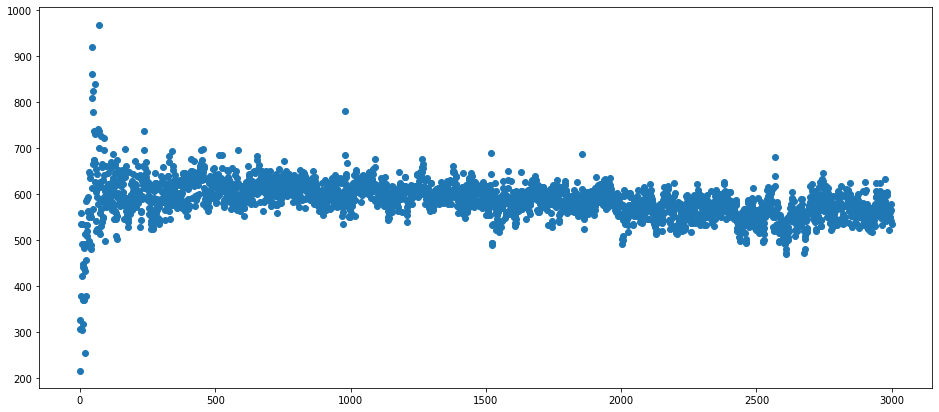

In [15]:
plt.figure(0, figsize=(16,7))
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.scatter(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [13]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

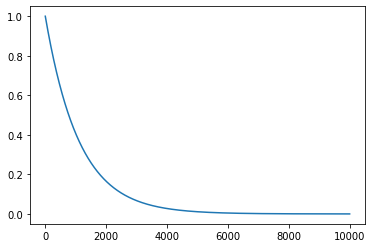

In [14]:
plt.plot(time, epsilon)
plt.show()